In [1]:
from astropy.io import fits
from scipy.special import jv
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import copy as cp
import scipy
hdul = fits.open("GLEAM_EGC_v2.fits")

%matplotlib notebook


In [2]:
def generate_beam(alt,az,freq):
    
    
    x = np.expand_dims((np.cos(alt)*np.cos(az)), axis=-1)
    y = np.expand_dims((np.cos(alt)*np.sin(az)), axis=-1)
    
    k = 2*np.pi*freq/(3*10**8)
    xpc = 0 #np.random.randn()
    ypc = 0 #np.random.randn()
    ax = 6 #+ np.random.randn()
    ay = 6 #+ np.random.randn()
    
    top = 2*jv(1,k*np.sqrt((ax**2)*((x-xpc)**2) + (ay**2)*(y-ypc)**2))
    bot = k*np.sqrt((ax**2)*((x-xpc)**2) + (ay**2)*(y-ypc)**2)
    beam = (top/bot)**2
    beam *= (np.expand_dims(alt, axis = -1)> 0)
    
    return beam

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in greater


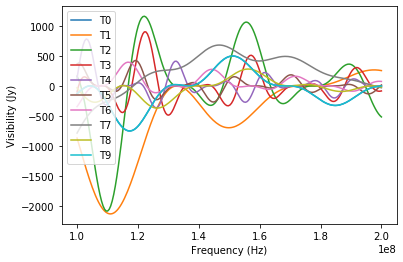

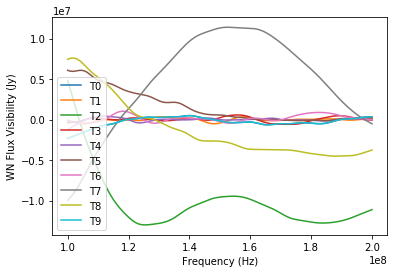

In [3]:
import hera_cal
from hera_cal.redcal import get_pos_reds
from hera_sim import antpos


# TEMPLATE
# def visibilities(self, freqs, ant1, ant2):
#     beams = np.sqrt(ant1.generate_beam(self.alts, self.azs, freqs)*ant2.generate_beam(self.alts, self.azs, freqs))
#     fluxes = self.refFluxes * np.outer(freqs,(self.refFreqs**-1)) ** (-self.alphas)
#     blvec = ant1.getblVector(ant2)
#     exponents = np.exp(np.outer(-2.0j*np.pi/(3.0e8/freqs),blvec.dot(self.carts)))
#     visibility = np.sum(fluxes * beams * exponents, axis=1)
#     return visibility


# should be inputting A SINGLE BL VECTOR; a single "entry"
def visibility(baseline,freqs,LSTs,RA,DEC,alpha,flux_val,reffreqs,noise_level=0.05):
    # order of dimensions: positions, times, sources, freqs
    c = 3*10**8
    k = 2*np.pi*freqs/c
    
    lat = -30.722 # observer's latitude, given in the paper
    
    h = np.deg2rad(LSTs[:,np.newaxis] - RA[np.newaxis,:]) # dim: times, sources
    #print("h shape: ",h.shape)
    d = np.deg2rad(DEC) 
    L = np.deg2rad(lat)
    
    # azimuth and altitude
    #az = np.arctan(np.sin(h)/(np.cos(h)*np.sin(L) - np.tan(d)*np.cos(L)))
    az = np.arctan2(np.sin(h)*np.cos(d), (np.cos(h)*np.cos(d)*np.sin(L) - np.sin(d)*np.cos(L))) + np.pi
    #alt = np.arcsin(np.sin(L)*np.sin(h) + np.cos(L)*np.cos(d)*np.cos(h))
    alt = np.arcsin(np.sin(L)*np.sin(d) + np.cos(L)*np.cos(d)*np.cos(h))
    #print(az.shape)
    #print(alt.shape)
    
    #return alt,az
    
    x = (np.cos(alt)*np.cos(az))
    y = (np.cos(alt)*np.sin(az))
    z = np.sin(alt)
    
    r = np.array([x,y,z])
    #print("r:",r.shape)
    
    #airy_beam = np.sqrt(generate_beam(r,freqs)*generate_beam(r,freqs))
    # NOTE: Fix the dimensions of this one: should have dependency on:
    # times, sources, freqs
    airy_beam = generate_beam(alt,az,freqs)
    #print("beam shape: ",airy_beam.shape)
    
    #airy_beam = np.ones_like(airy_beam)
    
    # order of dimensions: positions, times, sources, freqs
    bdotr = np.einsum('i,ijk',baseline,r)[:,:,np.newaxis]
    #print("b dot r shape: ",bdotr.shape)
    exponential = np.exp(-2.0j*np.pi*(freqs[np.newaxis,np.newaxis,:]/(3*10**8))*bdotr)
    #print("exponential shape: ",exponential.shape)
    
    ### adding white noise: flux as a function of frequency, no power law (no alpha), with added
    ### Gaussian white noise  (np.random.randn somewhere....)
    wn_flux = flux_val[:,np.newaxis]*(freqs[np.newaxis,:]/reffreqs[:,np.newaxis]) + noise_level*np.random.randn() 
    
    flux = flux_val[:,np.newaxis]*(freqs[np.newaxis,:]/reffreqs[:,np.newaxis])**alpha[:,np.newaxis]
    #print("Flux: ",flux.shape)
    
    vis = flux[np.newaxis,:] * airy_beam * exponential
    wn_vis = wn_flux[np.newaxis,:] * airy_beam *exponential
    
    # axis that should be summmed over: "sources". As of right now, that happens to be the 3rd axis
    # power law vis first, white noise vis 2nd
    return np.sum(vis,axis = 1), np.sum(wn_vis,axis = 1)



#np.argwhere(hdul[1].data["int_flux_151"]>25), np.argwhere(bool) returns indices where the
#condition is true
flux_vals = hdul[1].data["int_flux_151"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
RAs = hdul[1].data["RAJ2000"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
DECs = hdul[1].data["DEJ2000"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
alphas = hdul[1].data["alpha"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]

test_bl = np.array([10,30,0])
reffreqs = 151*np.ones_like(flux_vals)
LSTs = np.linspace(0,360,10)
#print("flux_vals shape: ",flux_vals.shape)
#print("reffreqs shapes: ",reffreqs.shape)


# frequency spectrum:
test_freqs = np.linspace(100e6,200e6,200)



# baseline,freqs,LSTs,RA,DEC,alpha,flux_val,reffreqs
Vtotal_test, wn_Vtotal_test = visibility(test_bl,test_freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs)
#print("Shape Vtotal: ",Vtotal_test.shape)

plt.figure()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Visibility (Jy)")
for i in range(10):
    plt.plot(test_freqs, Vtotal_test.real[i],label= "T" + str(i))

plt.legend()
plt.show()


plt.figure()
plt.xlabel("Frequency (Hz)")
plt.ylabel("WN Flux Visibility (Jy)")
for i in range(10):
    plt.plot(test_freqs, wn_Vtotal_test.real[i],label= "T" + str(i))
plt.legend()
plt.show()

(100,)
(100, 200)


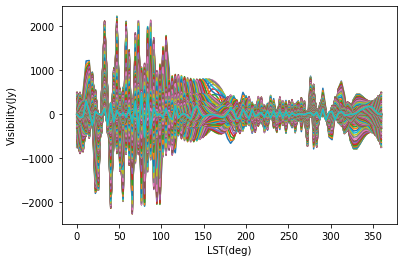

In [4]:
LST2 = np.linspace(0,360,100)
VIS2,wn_VIS2 = visibility(test_bl,test_freqs,LST2,RAs,DECs,alphas,flux_vals,reffreqs)

print(LST2.shape)
print(VIS2.shape)

plt.figure()
plt.xlabel("LST(deg)")
plt.ylabel("Visibility(Jy)")
plt.plot(LST2, VIS2.real)
plt.show()

In [5]:
reffreqs = 151*np.ones_like(flux_vals)
LSTs = np.linspace(0,360,4)
freqs = reffreqs[np.newaxis,:]
times = LSTs[:,np.newaxis]
result = freqs*times


Now, let's try adding perturbations again:
- compare visibilities of perturbed antenna position system vs non-perturbed system
- average value of the visibilities
- plot: Real vs. Im, probably at one fixed time and freq for a scatter/point plot
- quantity: average of |(average value of the perturbed (over 1 group of red baselines)/ true value of the unperturbed (true value of unperturbed group))| per baseline group per times
- idea: how much signal do we actually lose?
- is it a function of baselines? of frequencies?

How does the error in amplitude and phase change with respect to baseline, frequency, time, antpos error level? 

In [6]:
from tqdm import tqdm_notebook as tqdm

In [17]:
  def find_amp_err(baseline,antpos,antposP,freqs,freq_ind,LSTs,LST_ind,err_tol):
    '''Figure out error in amplitude and phase for a given baseline, frequency, and time. 
    Returns list in the form of [amplitude error, phase error].
    Args:
        baseline: 2-element array specifying the magnitude and direction between two antennae.
        antpos: dict of unperturbed antenna positions.
        antposP: antpos, with added perturbations
        freqs: array of frequencies
        freq_ind: int, index of frequency of interest
        LSTS: array of times
        LST_ind: int, index of time of interest
        err_tol: size of allowable difference between two baselines such that they are still redundant.
        '''
    
    reds = get_pos_reds(antpos,err_tol)
    redsP = get_pos_reds(antposP,err_tol)
    
    # find the set of redundant baselines in "reds" when given a specific baseline
    for i in range(len(reds)):
        if np.all([(antpos[reds[i][0][1]] - antpos[reds[i][0][0]]),baseline]):
            reds_ind = i
            break
    red = reds[reds_ind]
    redP = redsP[reds_ind]
    
    # grab the visibilities from those redundant baselines
    perturbed_vis = {}
    wn_perturbed_vis = {}
    for bl in tqdm(redP,desc="perturbed vis loop"):
        blvec = np.append((antposP[bl[1]] - antposP[bl[0]]),0)
        perturbed_vis[bl],wn_perturbed_vis[bl] = visibility(blvec,freqs,LSTs,
                                                            RAs,DECs,alphas,flux_vals,reffreqs)
    # can do easier method with unperturbed
    unperturbed_vis = {}
    wn_unperturbed_vis = {}
    unperturb_blvec = np.append((antpos[red[0][1]] - antpos[red[0][0]]),0)
    unperturb_vis_value, wn_unperturb_vis_value = visibility(blvec,freqs,LSTs,
                                                             RAs,DECs,alphas,flux_vals,reffreqs)
    
    for bl in tqdm(red,desc='unperturbed loop'):
        unperturbed_vis[bl] = unperturb_vis_value
        wn_perturbed_vis[bl] = wn_unperturb_vis_value
        
#     unperturbed_vis2 = {}
#     for bl in tqdm(red):
#         blvec = np.append((antpos[bl[1]] - antpos[bl[0]]),0)
#         unperturbed_vis2[bl] = visibility(blvec,freqs,LSTs,RAs,DECs,
#                                          alphas,flux_vals,reffreqs)
#     print(len(unperturbed_vis))
#     print(len(unperturbed_vis2))
    

    vis_here_unpert = np.array([vis[LST_ind,freq_ind] for vis in unperturbed_vis.values()])
    vis_here = np.array([vis[LST_ind,freq_ind] for vis in perturbed_vis.values()])
    
    unpert_amp = np.abs(np.mean(vis_here_unpert))
    #print("unpert_amp: ",unpert_amp)
    unpert_phase = np.angle(np.mean(vis_here_unpert))
    #print('unpert_phase: ',unpert_phase)
    pert_amp = np.abs(np.mean(vis_here))
    #print("pert_amp: ",pert_amp)
    pert_phase = np.angle(np.mean(vis_here))
    #print("pert_phase: ",pert_phase)
    
    err_amp = (pert_amp - unpert_amp)/unpert_amp
    err_phase = (pert_phase - unpert_phase)

    return np.array([err_amp,err_phase])



Breaking the Function Down into Smaller Pieces:

9/6
- values of dictionaries can be dictionaries (can't be the keys though)


`dictionary[error level][unique baseline tuple (first baseline in each red)] = np.array(Ntimes,Nfreqs)`

* Simulate the unperturbed visibilities
* Loop over position error levels:
    * Simulate perturbed visibilities
    * Loop over unique baselines:
        * Calculate phase and amplitude errors for each unique baseline for all times and frequencies (use the unperturbed list of redundancies to avoid tolerance issues)
        * Save those values in some sort of nested dictionary (see above)
* plot phase and amplitude errors vs. position error level, baseline length, time, frequency

In [18]:

antpos = {}
n = 0
for i in np.arange(0,100.0,10):
    for j in np.arange(0,100.0,10):
        n += 1
        antpos[n] = np.array([i,j])

np.random.seed(1)
antposP = cp.deepcopy(antpos)
for n in antposP.keys():
    antposP[n] += np.random.randn(2)*0.5
    
assert len(get_pos_reds(antposP,bl_error_tol=4)) == len(get_pos_reds(antpos))

In [19]:
baseline = np.array([1,2])
test_freq_ind = 101
LST_ind = 5
err_tol = 1

#find_amp_err(baseline,antpos,antposP,test_freqs,test_freq_ind,LSTs,LST_ind,err_tol)

In [20]:
def improved_vis_finder(baseline,antpos,antposP,freqs,LSTs,err_tol):
    '''Figure out visibility for a given baseline, set of antennae positions
    (as well as the perturbed set), frequency, and time. 
    Returns list in the form of [unperturbed visibilities, perturbed visibilities].
    Args:
        baseline: 2-element array specifying the magnitude and direction between two antennae.
        antpos: dict of unperturbed antenna positions.
        antposP: antpos, with added perturbations
        freqs: array of frequencies
        LSTS: array of times
        err_tol: size of allowable difference between two baselines such that they are still redundant.
        '''
    
    reds = get_pos_reds(antpos,err_tol)
    redsP = get_pos_reds(antposP,err_tol)
    
    # find the set of redundant baselines in "reds" when given a specific baseline
    for i in range(len(reds)):
        if np.all([(antpos[reds[i][0][1]] - antpos[reds[i][0][0]]),baseline]):
            reds_ind = i
            break
    red = reds[reds_ind]
    redP = redsP[reds_ind]
    
    # grab the visibilities from those redundant baselines
    perturbed_vis = {}
    wn_perturbed_vis = {}
    for bl in tqdm(redP,desc="perturbed vis loop"):
        blvec = np.append((antposP[bl[1]] - antposP[bl[0]]),0)
        perturbed_vis[bl], wn_perturbed_vis[bl] = visibility(blvec,freqs,LSTs,RAs,DECs,
                                                        alphas,flux_vals,reffreqs)
    # technically, I can just grab the the vis from the first element, but running the whole thing
    # to be safe
    # maybe not do that 
    unperturbed_vis = {}
    wn_unperturbed_vis = {}
    unperturb_blvec = np.append((antpos[red[0][1]] - antpos[red[0][0]]),0)
    unperturb_vis_value, wn_unperturb_vis_value = visibility(blvec,freqs,LSTs,RAs,DECs,
                                                             alphas,flux_vals,reffreqs)
    
    for bl in tqdm(red,desc='unperturbed loop'):
        unperturbed_vis[bl] = unperturb_vis_value
        unperturbed_vis[bl]  = wn_unperturb_vis_value
    
    return [unperturbed_vis,perturbed_vis]

[unp_vis, p_vis] = improved_vis_finder(np.array([1,2]),antpos,antposP,test_freqs,LSTs,err_tol)



In [21]:
def phase_and_amp_err_finder(unperturbed_vis,perturbed_vis):
    '''Given an unperturbed and perturbed set of visibilities, find the error in amplitude and
    phase for a specific time and frequency. Returns: (error amplitude, error phase)'''
    vis_here_unpert = np.array([vis for vis in unperturbed_vis.values()])
    vis_here = np.array([vis for vis in perturbed_vis.values()])
    
    unpert_amp = np.abs(vis_here_unpert[0])
    unpert_phase = np.angle(vis_here_unpert[0])

    pert_amp = np.abs(np.mean(vis_here,axis=0))
    
    pert_phase = np.angle(np.mean(vis_here,axis=0))
    
    err_amp = (pert_amp - unpert_amp)/unpert_amp
    # try using np.unwrap here instead to fix the wrapping problem
    err_phaseV2 = np.unwrap((pert_phase - unpert_phase))

    return err_amp,err_phaseV2

In [22]:
flux_vals = hdul[1].data["int_flux_151"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
RAs = hdul[1].data["RAJ2000"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
DECs = hdul[1].data["DEJ2000"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
alphas = hdul[1].data["alpha"][np.argwhere(hdul[1].data["int_flux_151"]>25).reshape(-1)]
reffreqs = 151*np.ones_like(flux_vals)

LSTs = np.linspace(0,360,10)
test_freqs = np.linspace(100e6,200e6,200)

###
test_bl = np.array([10,30,0])
Vtotal_test,wn_Vtotal_test = visibility(test_bl,test_freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs)
print(Vtotal_test.shape)
print(wn_Vtotal_test.shape)

(10, 200)
(10, 200)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [23]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [24]:
%lprun -f find_amp_err find_amp_err(baseline,antpos,antposP,test_freqs,test_freq_ind,LSTs,LST_ind,err_tol)

8/09:
- break down function into smaller pieces; have one do the visibility simulation and hold onto that info, and the other can find the amp/phase error
- change how we get unperturbed_vis back to just grabbing the first element and making an array from that
- eventually, we'd like to do calculations over all the different baselines. Thus, it'd make sense to break it down first.
- still need to work on last week's question by:
    - more sensible definition of phase errors: "phase wrapping", +pi to -pi, probably need to use mod
    - just be careful about those phase values; should print them out once to look
- goal: plotting the error with respect to each/all the variables
    - position error levels: 1mm, 5mm, 1cm, 5cm, 10cm, 50cm; or try np.logspace divisions
    - generally: error tolerance is 4 times the largest position error
    - setting random seed(s)? 
- comparing the power spectra of the perturbed and the unperturbed systems
- how to get it below

9/6
- values of dictionaries can be dictionaries (can't be the keys though)


`dictionary[error level][unique   baseline tuple (first baseline in each red)] = np.array(Ntimes,Nfreqs)`

* ^Simulate the unperturbed visibilities 
* Loop over position error levels:
    * Simulate perturbed visibilities
    * Loop over unique baselines:
        * Calculate phase and amplitude errors for each unique baseline for all times and frequencies ~(use the unperturbed list of redundancies to avoid tolerance issues)~
        * Save those values in some sort of nested dictionary (see above)
* plot phase and amplitude errors vs. position error level, baseline length, time, frequency
    

In [25]:
# finding unique baselines, now with random.seed involved
antpos = {}
n = 0
for i in np.arange(0,100.0,10):
    for j in np.arange(0,100.0,10):
        n += 1
        antpos[n] = np.array([i,j])

np.random.seed(1)
antposP = cp.deepcopy(antpos)
for n in antposP.keys():
    antposP[n] += np.random.randn(2)*0.5
    
assert len(get_pos_reds(antposP,bl_error_tol=4)) == len(get_pos_reds(antpos))

In [26]:
# it's about time I made a function for this:
def generate_antpos(length, N,pert_size):
    '''Generates dictionary of antenna positions in a NxN grid as well as a copy of those positions
    with slight perturbations. Returns tuple in the form of unperturbed positions, perturbed positions.
    
    Args:
    length: physical length of one whole side (meters)
    N: number of antennae per row and per column
    pert_size: size of the Gaussian perturbation of the antannae positions away from their ideal
    spots.'''
    antpos = {}
    index = 0
    for i in np.arange(0,length,N):
        for j in np.arange(0,length,N):
            index += 1
            antpos[index] = np.array([i,j])

    np.random.seed(1)
    antposP = cp.deepcopy(antpos)
    for index in antposP.keys():
        antposP[index] += np.random.randn(2)*pert_size

    return antpos,antposP

antpos,antposP = generate_antpos(100.0,10,0.02)

In [27]:
#antposP[1]
redsP = get_pos_reds(antposP,bl_error_tol=1)
reds = get_pos_reds(antpos,bl_error_tol=1)

Notes for 10/18:
- continue working on graphing the outputs, try different combinations of variables
- try moving the relevant stuff to a new notebook entirely
- try writing pseudo code first to get a clear idea of what you want to happen and then execute on that
- the simulation step should only be a few lines that don't need to be rerun
- For the unperturbed: only calculate for the 1st term in each redundancy
- write the loops such that the unperturbed processes are not duplicated
- perturbed and make a separate one called "average perturbed" 
- start with perturbations ~ 2cm instead of 0.5m (wavelengths are about 2m)
- averaged perturbed vs. unperturbed: look at the power spectra


Notes for 11/12:
- combine vis_pert and vis_unpert if possible; some repeated lines in those
- Fix the Pert vis function
- "does the decoherence of the foreground spectrum tell us anything about the whole power spectrum?"
    - measure decoherence as a function of perturbed baseline (and eventually pert beams)
    - see if there is the same level of decoherence at higher modes of the Fourier spectrum
- power spectra: difference in Fourier amplitudes
- decoherence: difference between the power spectra of the unpert set vs power spectra of pert set
1. find visibilities of unpert (can cheat and not average over unpert)
2. find visibilities of pert (remember, average the visibilites, not the baselines)
3. find the amplitude of the complex differences (this is a new one; might be more useful than the error in phases)
4. find the differences in the amplitudes
5. could also find the amplitude of the phase differences as well
6. Build power spectra for the pert set of visibilities; plot
- power spectra  = Fourier transform squared
7. And for the unpert set as well; plot
8. Expectation: pert amplitude should be smaller than unpert (see quarter circle plot on the messier notebook)
9. Computing power spectra example somewhere in the notebook
10. Change the functions to take in set of redundant baseline tuples instead of antpos; this way we can choose to take however many unique baselines there are in the calculation


Unperturbed vis function:
    - get reds from antpos
    - initialize dictionary
    - for each unique baseline:
        - to find the baseline value that represents the whole set, just take the first element and find the difference between the coordinate values
        - find visibility using that baseline value
            - assign that visibility into a dictionary,s.t. it can be tracked via the coordinate tuple
            - note: I've done this by taking the 1st element of each set of unique baselines as the key for the vis of the whole group



Perturbed vis function:
    - get reds from antpos
    - initialize dictionary
    - for each unique baseline:
        - find the exact value of each baseline
        - find visibility using that baseline value
            - ***find the average over all of of these visibilities***
        - assign that visibility into a dictionary,s.t. it can be tracked via the coordinate tuple
        - note: I've done this by taking the 1st element of each set of unique baselines as the key for the vis of the whole group


In [28]:
### testing logic

print(LSTs)
vlist = []
v1,wn_v1 = visibility(np.array([1,0,0]),test_freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs)
v2,wn_v2 = visibility(np.array([2,0,0]),test_freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs)
v_test,wn_v_test = visibility(test_bl,test_freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs)
print(v_test.shape)
print(v1.shape)
print(v2.shape)
asdf1 = np.append(v1,v2,axis=0)
asdf2 = np.append(v1,v2,axis=1)
vlist.append(v1)
vlist.append(v2)
print(np.array(vlist).shape)
avg_vlist = np.average(vlist,axis=0)
print(avg_vlist.shape)
#print(flux_vals.shape)

asd = np.append(np.array([1,2,3]),4)
print(asd)

[  0.  40.  80. 120. 160. 200. 240. 280. 320. 360.]
(10, 200)
(10, 200)
(10, 200)
(2, 10, 200)
(10, 200)
[1 2 3 4]


In [30]:
### Fixed: average of the visibilities, not average of the baselines
### also: use 'test_freqs' in the 'freqs' arg for these things, for consistency
def vis_pert(antposP,freqs,LSTs,bl_error_tol=1):
    reds = get_pos_reds(antposP,bl_error_tol)
    pert_vis_dict = {}
    wn_pert_vis_dict = {}
    for i in tqdm(range((len(antposP)+1)),desc='"vis_pert" loop'):
        setvis = []
        setwnvis = []
        for bl in reds[i]:
            pert_blvec = np.append((antposP[bl[1]] - antposP[bl[0]]),0)
            
            #pert_blvec = (antposP[bl[1]] - antposP[bl[0]]).tolist()
            #print(type(pert_blvec))
            pert_vis_value,wn_pert_vis_value = visibility(pert_blvec,freqs,LSTs,RAs,DECs,
                                                          alphas,flux_vals,reffreqs)
            setvis.append(pert_vis_value)
            setvis.append(wn_pert_vis_value)
            
        avg_pert_vis = np.average(np.array(setvis),axis=0)
        avg_wn_pert_vis = np.average(np.array(setwnvis),axis=0)
        wn_pert_vis_dict[reds[i][0]] = avg_wn_pert_vis
        
        
    return pert_vis_dict

#print(len(vis_pert(antposP,test_freqs,LSTs,bl_error_tol=1)))


In [31]:
### takes a while to run!!!
#test_vis_pert = vis_pert(antposP,test_freqs,LSTs,bl_error_tol=1)

In [32]:
#test_vis_pert[(1,2)].shape

In [33]:
# function: unperturbed vis from antpos, for ALL baselines
def vis_unpert(antpos,freqs,LSTs):
    reds = get_pos_reds(antpos)
    unpert_vis_dict = {}
    wn_unpert_vis_dict = {}
    for i in tqdm(range(1,(len(antpos)+1)),desc='"vis_unpert" loop'):
        unpert_blvec = np.append((antpos[reds[i][0][1]] - antpos[reds[i][0][0]]),0)
        unpert_vis_value, wn_unpert_vis_value = visibility(unpert_blvec,freqs,LSTs,RAs,DECs,
                                                           alphas,flux_vals,reffreqs)
        unpert_vis_dict[reds[i][0]] = unpert_vis_value
        wn_unpert_vis_dict[reds[i][0]] = wn_unpert_vis_value
    return unpert_vis_dict

#print(len(vis_unpert(antpos,test_freqs,LSTs)))


In [34]:
test_vis_unpert = vis_unpert(antpos,test_freqs,LSTs)

In [35]:
test_vis_unpert[(1,5)].shape

(10, 200)

12/3 
- fix bug that produces the same visibility for very different baselines
- quantifying decoherance using the ratio method, and comparing the values at delay = 0
    - compare these as a function of perturbation level
    - other things: time, baseline length
- do the above for white noise spectrum
    - Gaussian white noise, a property of the source, should be a function of frequency. 
    - check the visibility() function to see what I'm talking about; there's a comment that explains it a little better there
    

180

In [52]:
def pert_and_unpert_vis(antpos,antposP,freqs,LSTs,RAs,DECs,alphas,flux_vals,reffreqs):
    #redsP = get_pos_reds(antposP,bl_error_tol)
    pert_vis_dict = {}
    wn_pert_vis_dict = {}
    unpert_vis_dict = {}
    wn_unpert_vis_dict = {}
    reds = get_pos_reds(antpos)
    ## !!!!!!!!! [0:10] just in there for testing!! take it out for long term
    for red in tqdm(reds,desc='loop time'):
        
        # processing perturbed
        setvis = []
        setwnvis = []
        for bl in red:
            pert_blvec = np.append((antposP[bl[1]] - antposP[bl[0]]),0)
            pert_vis_value,wn_pert_vis_value = visibility(pert_blvec,freqs,LSTs,RAs,DECs,
                                                          alphas,flux_vals,reffreqs)
            setvis.append(pert_vis_value)
            setvis.append(wn_pert_vis_value)
            
        avg_pert_vis = np.average(np.array(setvis),axis=0)
        avg_wn_pert_vis = np.average(np.array(setwnvis),axis=0)
        pert_vis_dict[red[0]] = avg_pert_vis
        wn_pert_vis_dict[red[0]] = avg_wn_pert_vis
        
          # processing uneperturbed
        
        unpert_blvec = np.append((antpos[red[0][1]] - antpos[red[0][0]]),0)
        unpert_vis_value, wn_unpert_vis_value = visibility(unpert_blvec,freqs,LSTs,RAs,DECs,
                                                           alphas,flux_vals,reffreqs)
        unpert_vis_dict[red[0]] = unpert_vis_value
        wn_unpert_vis_dict[red[0]] = wn_unpert_vis_value
        
    return unpert_vis_dict,pert_vis_dict

In [53]:
### long runtime! Not too bad though. ###
test_unpert_vis_dict,test_pert_vis_dict = pert_and_unpert_vis(antpos,
                                                          antposP,
                                                          test_freqs,
                                                          LSTs,
                                                          RAs,
                                                          DECs,
                                                          alphas,
                                                          flux_vals,
                                                          reffreqs)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
print(test_unpert_vis_dict[reds[0][0]][0].shape)
print(test_pert_vis_dict[redsP[0][0]][0].shape)

(200,)
(200,)


In [39]:
# now to figure out what the x axis is
# d = spacing between freqs
# delays = ft of freq = 1/[Hz] = [s]
delays = 1e9*np.fft.fftshift(np.fft.fftfreq(len(test_freqs),d=(test_freqs[1]-test_freqs[0]))) #ns
print(delays.shape)

(200,)


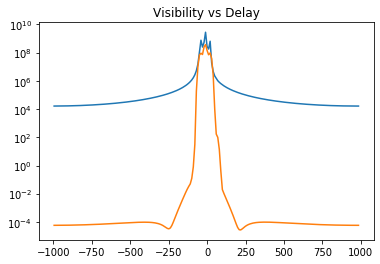

In [40]:
# pick one time, then plot fft
# default: choose LSTs[0], which is 0 degrees.
plt.figure()
plt.title('Visibility vs Delay')
plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(test_unpert_vis_dict[reds[0][0]][0]))**2))
# notice the tapering effect as a result of doing this
window = scipy.signal.blackmanharris(len(test_freqs))
plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(window*test_unpert_vis_dict[reds[0][0]][0]))**2))
# be sure to use the same windows for both pert and unpert
plt.show()

In [ ]:
%matplotlib notebook


In [ ]:
test_unpert_vis_dict.keys()

In [ ]:
bl = (3,11)
test_unpert_vis_dict[bl].shape

In [ ]:
plt.figure()
plt.title("Visibility vs frequency")
plt.xlabel('Frequency Hz')
plt.ylabel('Visibility Jy')
# plt.plot(test_freqs, np.abs(test_unpert_vis_dict[bl][0]),label='unpert vis')
# plt.plot(test_freqs, np.abs(test_pert_vis_dict[bl][0]),label='pert vis')
for bl in test_pert_vis_dict:
    #r = np.abs(test_pert_vis_dict[bl][0])/np.abs(test_unpert_vis_dict[bl][0])
    plt.plot(test_freqs, np.abs(test_unpert_vis_dict[bl][1]),label=bl)
    #plt.plot(test_freqs,r)
    plt.legend()
    plt.show()

In [ ]:
window = scipy.signal.blackmanharris(len(test_freqs))
                               
plt.figure()
plt.title('Visibility vs Delay')
plt.xlabel('Delay (ns)')
plt.ylabel('Visibility (Jy)')
    #plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(test_unpert_vis_dict[reds[0][0]][0]))**2))
    # notice the tapering effect as a result of doing this
    # plt.semilogy(delays,fft_unpert_vis),'ro',label='unperturbed')
    # plt.semilogy(delays,fft_pert_vis),'bx',label='perturbed')
for bl in test_unpert_vis_dict:
    fft_unpert_vis = np.fft.fftshift(np.abs(np.fft.fft(window*test_unpert_vis_dict[bl][0]))**2)
    fft_pert_vis = np.fft.fftshift(np.abs(np.fft.fft(window*test_pert_vis_dict[bl][0]))**2)
    ratio = fft_pert_vis/fft_unpert_vis
    plt.plot(delays,ratio,label=bl)                        
    plt.legend()
plt.show()

In [ ]:
window = scipy.signal.blackmanharris(len(test_freqs))
for key in test_unpert_vis_dict:
    plt.figure()
    plt.title('Visibility vs Delay')
    plt.xlabel('Delay (ns)')
    plt.ylabel('Visibility (Jy)')
    #plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(test_unpert_vis_dict[reds[0][0]][0]))**2))
    # notice the tapering effect as a result of doing this
    plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(window*test_unpert_vis_dict[key][0]))**2),'ro',label='unperturbed')
    plt.semilogy(delays,np.fft.fftshift(np.abs(np.fft.fft(window*test_pert_vis_dict[key][0]))**2),'bx',label='perturbed')
    plt.legend()
    # be sure to use the same windows for both pert and unpert
plt.show()

In [ ]:
test_pert_vis_dict.keys()

In [ ]:
test_unpert_vis_dict.keys()

In [ ]:
# err_amp, err_phase = phase_and_amp_err_finder(perturbed_vis=test_vis_pert,unperturbed_vis=test_vis_unpert)

# plt.figure()
# plt.title("Error in Amplitude vs LST")
# plt.xlabel("LSTs (deg)")
# plt.ylabel("Error in Amplitude")
# plt.plot(LSTs,err_amp)

# plt.figure()
# plt.title("Error in Phase vs LST")
# plt.xlabel("LST (deg)")
# plt.ylabel("Error in Phase")
# plt.plot(LSTs,err_phase)

# plt.figure()
# plt.title("Error in Amplitude vs Frequency")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Error in Amplitude")
# plt.plot(test_freqs,err_amp.T)

# plt.figure()
# plt.title("Error in Phase vs Frequency")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Error in Phase")
# plt.plot(test_freqs,err_phase.T)

# plt.show()